# Задание **Ultra pro**
Макс 10 баллов

Возьмите собственную базу изображений и их сегментированных изображений. И обучите модель сегментировать изображение на заданные классы.

# **Semantic Segmentation of Underwater Imagery (SUIM)**
**Семантическая сегментация подводных изображений**

Данный датасет взят с сайта kaggle.com

https://www.kaggle.com/ashish2001/semantic-segmentation-of-underwater-imagery-suim



## Описание

  - Этот набор данных содержит более **1500** изображений с пиксельными аннотациями для восьми категорий объектов: рыбы (позвоночные), рифы
(беспозвоночные), водные растения, затонувшие корабли/руины, люди-дайверы, роботы и морское дно.

  - Он также включает в себя тестовый набор из **110** изображений.

  - Все изображения имеют переменное разрешение для целей бенчмаркинга можно использовать размер (320x240) или (320x256)

  - Выступает в качестве эталонного набора данных для сегментации подводных изображений.

   - Фон                             - **ЧЕРНЫЙ**
   - Дайверы	                       - **СИНИЙ**
   - Водные растения и морская трава	- **ЗЕЛЕНЫЙ**
   - Затонувшие корабли и руины      - **ГОЛУБОЙ**
   - Роботы                          - **КРАСНЫЙ**
   - Рифы и беспозвоночные	          - **РОЗОВЫЙ**
   - Рыбы и позвоночные	            - **ЖЕЛТЫЙ**
   - Морское дно и скалы	            - **БЕЛЫЙ**

## Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import concatenate, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from google.colab import files
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import random
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Задание глобальных параметров

In [ ]:
# img_width  = 240     # Ширина
# img_height = 320     # Высота

img_width  = 120     # Ширина
img_height = 160     # Высота

chanels    = 3       # Кол-во каналов

# Пути к обучающей и проверочной выборок  
train_images_directory = '/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/train/images/'
train_masks_directory  = '/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/train/masks/'
val_images_directory = '/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/val/images/'
val_masks_directory  = '/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/val/masks/'

num_classes = 8      # Количество классов

## Загрузка изображений



### Оригинальные изображения

In [ ]:
train_images = []  # Список обучающей выборки
val_images = []    # Список проверочной выборки

curr_time = time.time()
for filename in sorted(os.listdir(train_images_directory)):
  train_images.append(image.load_img(os.path.join(train_images_directory, filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(train_images))

curr_time = time.time()
for filename in sorted(os.listdir(val_images_directory)):
  val_images.append(image.load_img(os.path.join(val_images_directory, filename), target_size=(img_width, img_height)))
print (f'Проверочная выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунд')
print ('Количество изображений: ', len(val_images))

Обучающая выборка завершина. Время загрузки: 32.42 cекунд
Количество изображений:  1525
Проверочная выборка завершина. Время загрузки: 1.69 cекунд
Количество изображений:  110


### Проверка полученных  оригинальных изображений

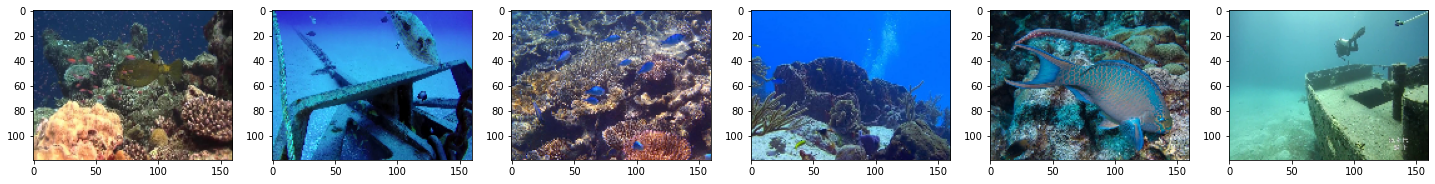

In [ ]:
n = 6
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(train_images)
  axs[i].imshow(img)
plt.show()

### Загрузка **сегментированных** изображения

In [ ]:
train_segments = []
val_segments = []

curr_time = time.time()
for filename in sorted(os.listdir(train_masks_directory)):
  train_segments.append(image.load_img(os.path.join(train_masks_directory, filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунды')
print ('Количество изображений: ', len(train_segments))

curr_time = time.time()
for filename in sorted(os.listdir(val_masks_directory)):
  val_segments.append(image.load_img(os.path.join(val_masks_directory, filename), target_size=(img_width, img_height)))
print (f'Обучающая выборка завершина. Время загрузки: {round(time.time() - curr_time, 2)} cекунды')
print ('Количество изображений: ', len(val_segments))

Обучающая выборка завершина. Время загрузки: 84.33 cекунды
Количество изображений:  1525
Обучающая выборка завершина. Время загрузки: 3.17 cекунды
Количество изображений:  110


### Проверка полученных **сегментированных** изображений

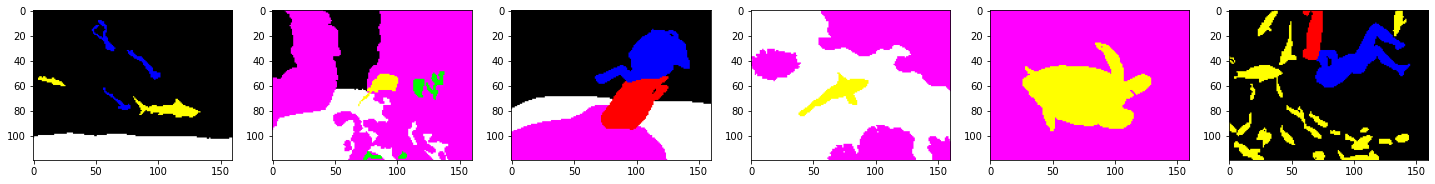

In [ ]:
n = 6
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i in range(n):
  img = random.choice(train_segments)
  axs[i].imshow(img)
plt.show()

## Создание выборки



In [ ]:
# Фон - ЧЕРНЫЙ
# Дайверы - СИНИЙ
# Водные растения и морская трава - ЗЕЛЕНЫЙ
# Затонувшие корабли и руины - ГОЛУБОЙ
# Роботы - КРАСНЫЙ
# Рифы и беспозвоночные - РОЗОВЫЙ
# Рыбы и позвоночные - ЖЕЛТЫЙ
# Морское дно и скалы - БЕЛЫЙ

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
    index=-1
    #        R                          G                        B
    if (29>=color[0]>=0)       and (29>=color[1]>=0)     and (29>=color[2]>=0)      : index=0 # ЧЕРНЫЙ - Фон

    elif (29>=color[0]>=0)     and (29>=color[2]>=0)     and (255>=color[1]>=100)   : index=1 # СИНИЙ - Дайверы

    elif (29>=color[0]>=0)     and (255>=color[1]>=100)  and (29>=color[2]>=0)      : index=2 # ЗЕЛЕНЫЙ - Водные растения и морская трава
  
    elif (29>=color[0]>=0)     and (255>=color[1]>=100)  and (255>=color[2]>=100)   : index=3 # ГОЛУБОЙ - Затонувшие корабли и руины

    elif (169>=color[0]>=255)  and (29>=color[1]>=0)     and (29>=color[2]>=0)      : index=4 # КРАСНЫЙ - Роботы
 
    elif (255>=color[0]>=100)  and (29>=color[1]>=0)     and (255>=color[2]>=100)   : index=5 # РОЗОВЫЙ - Рифы и беспозвоночные

    elif (255>=color[0]>=100)  and (255>=color[1]>=100)  and (29>=color[2]>=0)      : index=6 # ЖЕЛТЫЙ - Рыбы и позвоночные

    elif (255>=color[0]>=151)  and (255>=color[1]>=151)  and (255>=color[2]>=151)   : index=7 # БЕЛЫЙ - Морское дно и скалы
    
    else: index=0

    return index  

In [ ]:
# Из индекса в цвет
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if   index == 0: color = [0, 0, 0]         # ЧЕРНЫЙ - Фон
  elif index == 1: color = [0, 0, 255]       # СИНИЙ - Дайверы 
  elif index == 2: color = [0, 255, 0]       # ЗЕЛЕНЫЙ - Водные растения и морская трава
  elif index == 3: color = [0, 255, 255]     # ГОЛУБОЙ - Затонувшие корабли и руины
  elif index == 4: color = [255, 0, 0]       # КРАСНЫЙ - Роботы
  elif index == 5: color = [0, 255, 255]     # РОЗОВЫЙ - Рифы и беспозвоночные
  elif index == 6: color = [255, 0, 255]     # ЖЕЛТЫЙ - Рыбы и позвоночные
  elif index == 7: color = [255, 255, 255]   # БЕЛЫЙ - Морское дно и скалы
  return color

In [ ]:
# Функция перевода индекса пикслея в OHE
def rgbToOhe(y, num_classes):
  y_shape = y.shape                          # Запоминаем форму массива для решейпа
  y = y.reshape(y.shape[0] * y.shape[1], 3)
  yt = []
  for i in range(len(y)):
    yt.append(to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим в OHE
  yt = np.array(yt)
  yt = yt.reshape(y_shape[0], y_shape[1], num_classes)
  return yt

In [ ]:
# Функция формирования yTrain
def y_pred(data, num_classes):
  yTrain = []
  for seg in data:
    y = image.img_to_array(seg)   # Переводим изображение в numpy-массив
    y = rgbToOhe(y, num_classes)  # Получаем OHE
    yTrain.append(y)
    if len(yTrain) % 100 == 0:
      print(len(yTrain))
  return np.array(yTrain)

## Создание **xTrain** и **yTrain**

### xTrain, xVal

In [ ]:
xTrain = []
for img in train_images:
  x = image.img_to_array(img)
  xTrain.append(x)
xTrain = np.array(xTrain)

xVal = []
for img in val_images:
  x = image.img_to_array(img)
  xVal.append(x)
xVal = np.array(xVal)

print('xTrain: ', xTrain.shape)
print('xVal:   ', xVal.shape)

xTrain:  (1525, 120, 160, 3)
xVal:    (110, 120, 160, 3)


### yTrain, yVal

In [ ]:
curr_time = time.time()
yTrain = y_pred(train_segments, num_classes)
print (f'Время обработки: {round((time.time() - curr_time) / 60, 2)} минут')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
Время обработки: 21.66 минут


In [ ]:
curr_time = time.time()
yVal = y_pred(val_segments, num_classes)
print (f'Время обработки: {round((time.time() - curr_time) / 60, 2)} минут')

100
Время обработки: 1.58 минут


In [ ]:
print('xTrain: ', xTrain.shape)
print('yTrain: ', yTrain.shape)

print('xVal:   ', xVal.shape)
print('yVal:   ', yVal.shape)

xTrain:  (1525, 240, 320, 3)
yTrain:  (1525, 240, 320, 8)
xVal:    (110, 240, 320, 3)
yVal:    (110, 240, 320, 8)


## Сохранение и загрузка массивов  

In [ ]:
# Так как время создания выборки большое сохраним массивы на гугл диск
# # Сохранение
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/xTrain.npy', xTrain)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/yTrain.npy', yTrain)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/xVal.npy', xVal)
# np.save('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/yVal.npy', yVal)

# Загрузка
xTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/xTrain.npy')
yTrain = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/yTrain.npy')
xVal = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/xVal.npy')
yVal = np.load('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/yVal.npy')

In [ ]:
# #Выполнено сохранение [yTrain, yVal, xTrain, xVal]
# os.chdir('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/')
# #mega_arr=[yTrain, yVal, xTrain, xVal]
# with open('mega_arr.data', 'wb') as f:
#   pickle.dump([yTrain, yVal, xTrain, xVal], f)

Сохранение выборок в бинарный файл

In [ ]:
# #Выполнено сохранение [yTrain, yVal, xTrain, xVal]
# os.chdir('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM')
# #mega_arr=[yTrain, yVal, xTrain, xVal]
# with open('arr.data', 'wb') as f:
#   pickle.dump([yTrain, yVal, xTrain, xVal], f)



# Создание модели и дополнительные функции

### U-net

In [ ]:
def unet(num_classes=8, input_shape=(120,160,3)):
  img_input = Input(input_shape)                    # (240, 320, 3)

  # Block 1
  x = Conv2D(64, (3,3), padding='same')(img_input)  # (240, 320, 64)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)         # (240, 320, 64)   
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)              # (240, 320, 64)  

  x = MaxPooling2D()(block_1_out)                  # (120, 160, 64)

  # Block 2
  x = Conv2D(128, (3,3), padding='same')(x)         # (120, 160, 128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)         # (120, 160, 128)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)               # (120, 160, 128)

  x = MaxPooling2D()(block_2_out)                   # (60, 160, 128)

  # Block 3
  x = Conv2D(256, (3,3), padding='same')(x)         # (60, 160, 256)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)        # (60, 160, 256)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)         # (60, 160, 256)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)               # (60, 160, 256)

  x = MaxPooling2D()(block_3_out)                   # (30, 80, 256)

  # # Block 4
  # x = Conv2D(512, (3,3), padding='same')(x)         # (30, 80, 512)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)

  # x = Conv2D(512, (3,3), padding='same')(x)         # (30, 80, 512)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)

  # x = Conv2D(512, (3,3), padding='same')(x)         # (30, 80, 512)
  # x = BatchNormalization()(x)
  # block_4_out = Activation('relu')(x)               # (30, 80, 512)
  # x = MaxPooling2D()(block_4_out)                   # (15, 40, 512)

  # UP 2
  x = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(x)   # (30, 80, 256)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])             # (30, 80, 256) и (30, 80, 256)
  x = Conv2D(256, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), padding='same')(x)     # (30, 80, 256)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 3
  x = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(x)   # (60, 160, 128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])      
  x = Conv2D(128, (3,3), padding='same')(x)     # (60, 160, 128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), padding='same')(x)    # (60, 160, 128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 4
  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x) # (120, 160, 128) 
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)      # (120, 160, 128)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # # UP 4
  # x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x) # (120, 160, 128) 
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)

  # x = concatenate([x, block_1_out])
  # x = Conv2D(64, (3,3), padding='same')(x)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)

  # x = Conv2D(64, (3,3), padding='same')(x)      # (120, 160, 128)
  # x = BatchNormalization()(x)
  # x = Activation('relu')(x)


  x = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(x)  # (240,320, 8) 

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
# Собственная функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [ ]:
# Создание модели
model = unet()

### Просмотр модели

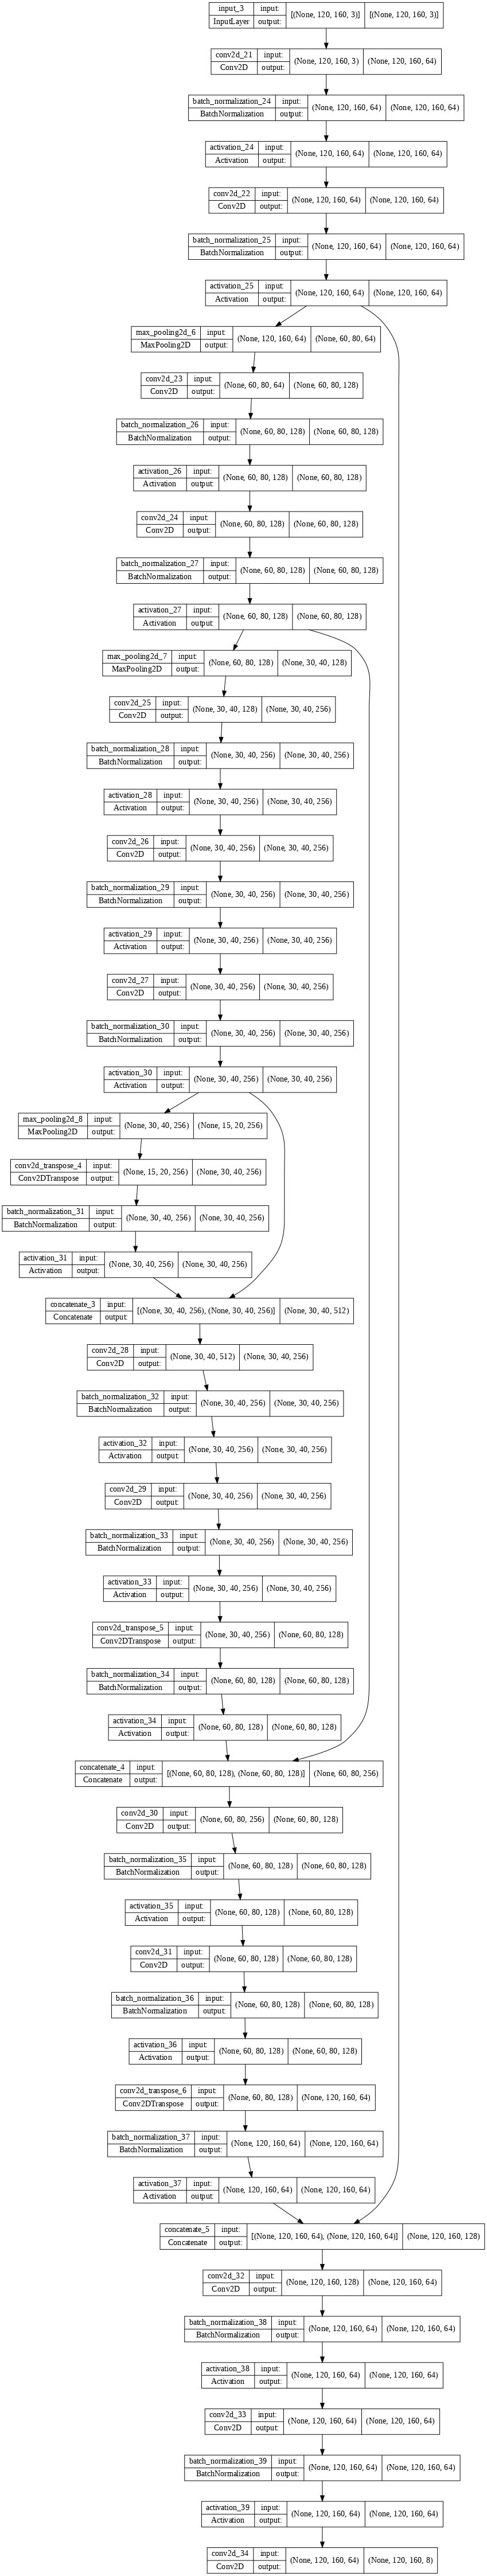

In [ ]:
plot_model(model, show_shapes=True, dpi=70)

## Обучение сети

In [ ]:
# # Создание модели
# model = unet()
# Обучение
history = model.fit(xTrain, yTrain, epochs=50, batch_size=32, validation_data=(xVal, yVal))

Epoch 1/50
48/48 [==============================] - 69s 1s/step - loss: 1.5187 - dice_coef: 0.3264 - val_loss: 1.6743 - val_dice_coef: 0.3928
Epoch 2/50
48/48 [==============================] - 42s 876ms/step - loss: 1.1666 - dice_coef: 0.4560 - val_loss: 1.3813 - val_dice_coef: 0.3883
Epoch 3/50
48/48 [==============================] - 42s 875ms/step - loss: 1.0696 - dice_coef: 0.4923 - val_loss: 1.2500 - val_dice_coef: 0.4138
Epoch 4/50
48/48 [==============================] - 42s 876ms/step - loss: 1.0077 - dice_coef: 0.5215 - val_loss: 1.1124 - val_dice_coef: 0.4532
Epoch 5/50
48/48 [==============================] - 42s 875ms/step - loss: 0.9707 - dice_coef: 0.5327 - val_loss: 1.0434 - val_dice_coef: 0.5096
Epoch 6/50
48/48 [==============================] - 42s 875ms/step - loss: 0.9396 - dice_coef: 0.5499 - val_loss: 0.9666 - val_dice_coef: 0.5427
Epoch 7/50
48/48 [==============================] - 42s 876ms/step - loss: 0.9143 - dice_coef: 0.5560 - val_loss: 0.9725 - val_dice_c

In [ ]:
print(f"Лучший результат при обучении: {max(history.history['val_dice_coef']) * 100}")

Лучший результат при обучении: 69.24970149993896


### Сохранение весов модели

In [ ]:
model.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/model.h5')

## Дообучение сети  **batch_size=50**

In [ ]:
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

history = model.fit(xTrain, yTrain, epochs=50, batch_size=50, validation_data=(xVal, yVal))

Epoch 1/50
31/31 [==============================] - 78s 2s/step - loss: 0.1925 - dice_coef: 0.8982 - val_loss: 1.0222 - val_dice_coef: 0.6774
Epoch 2/50
31/31 [==============================] - 45s 1s/step - loss: 0.1849 - dice_coef: 0.9016 - val_loss: 1.1132 - val_dice_coef: 0.6926
Epoch 3/50
31/31 [==============================] - 45s 1s/step - loss: 0.1826 - dice_coef: 0.9031 - val_loss: 1.0549 - val_dice_coef: 0.6721
Epoch 4/50
31/31 [==============================] - 45s 1s/step - loss: 0.1684 - dice_coef: 0.9100 - val_loss: 1.0049 - val_dice_coef: 0.6821
Epoch 5/50
31/31 [==============================] - 45s 1s/step - loss: 0.1593 - dice_coef: 0.9141 - val_loss: 1.0395 - val_dice_coef: 0.6843
Epoch 6/50
31/31 [==============================] - 45s 1s/step - loss: 0.1485 - dice_coef: 0.9196 - val_loss: 1.0716 - val_dice_coef: 0.7017
Epoch 7/50
31/31 [==============================] - 45s 1s/step - loss: 0.1571 - dice_coef: 0.9163 - val_loss: 1.2429 - val_dice_coef: 0.6532
Epoch 

In [ ]:
print(f"Лучший результат при обучении: {max(history.history['val_dice_coef']) * 100}")

Лучший результат при обучении: 72.36948013305664


### Сохранение весов модели

In [ ]:
model.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/model_two.h5')

## Дообучение сети  **batch_size=25, lr=0.00001**

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=[dice_coef])
history = model.fit(xTrain, yTrain, epochs=20, batch_size=25, validation_data=(xVal, yVal))

Epoch 1/20
61/61 [==============================] - 49s 769ms/step - loss: 0.0844 - dice_coef: 0.9522 - val_loss: 1.2235 - val_dice_coef: 0.7281
Epoch 2/20
61/61 [==============================] - 46s 758ms/step - loss: 0.0835 - dice_coef: 0.9524 - val_loss: 1.2642 - val_dice_coef: 0.7259
Epoch 3/20
61/61 [==============================] - 46s 758ms/step - loss: 0.0810 - dice_coef: 0.9538 - val_loss: 1.2791 - val_dice_coef: 0.7282
Epoch 4/20
61/61 [==============================] - 46s 758ms/step - loss: 0.0833 - dice_coef: 0.9527 - val_loss: 1.2336 - val_dice_coef: 0.7273
Epoch 5/20
61/61 [==============================] - 46s 757ms/step - loss: 0.0778 - dice_coef: 0.9553 - val_loss: 1.2654 - val_dice_coef: 0.7313
Epoch 6/20
61/61 [==============================] - 46s 757ms/step - loss: 0.0815 - dice_coef: 0.9538 - val_loss: 1.2522 - val_dice_coef: 0.7317
Epoch 7/20
61/61 [==============================] - 46s 758ms/step - loss: 0.0774 - dice_coef: 0.9554 - val_loss: 1.2878 - val_dic

In [ ]:
print(f"Лучший результат при обучении: {max(history.history['val_dice_coef']) * 100}")

Лучший результат при обучении: 73.16960096359253


### Сохранение весов модели

In [ ]:
model.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/model_two.h5')

## Распознавание



In [ ]:
# Если нужно то снова создадим модель и загрузим веса
#model = unet()
model.load_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/model.h5')

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count=6, n_classes=8):
  indexes = np.random.randint(0, len(xVal), count)
  print("indexes: ", indexes)
  
  fig, axs = plt.subplots(3, count, figsize=(25,7))
  for i, idx in enumerate(indexes):
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3)))
    #print("predict: ", predict.shape)

    pr = predict[0]
    #print("pr: ", pr.shape)

    pr1 = []                                # Сегментированная картинка из predicta
    yr2 = []                                # Сегменитрованная картинка из yVal

    pr = pr.reshape(-1, n_classes)          # Решейп предикта
    #print("pr(reshape): ", pr.shape)

    yr = yVal[idx].reshape(-1, n_classes)   # Решейп yVal
    #print("yr(reshape): ", yr.shape)

    for k in range(len(pr)):
      pr1.append(index2color(pr[k]))
      yr2.append(index2color(yr[k]))
    
    #print("pr1(list): ", len(pr1))
    #print("yr2(list): ", len(yr2))

    #print("len(pr1[0]): ", len(pr1[0]))
    pr1 = np.array(pr1)
    yr2 = np.array(yr2)
    #print("pr1(np.array): ", pr1.shape)
    #print("yr2(np.array): ", yr2.shape)

    pr1 = pr1.reshape(img_width, img_height, 3)
    #print("pr1(reshape): ", pr1.shape)

    yr2 = yr2.reshape(img_width, img_height, 3)
    #print("yr2(reshape): ", yr2.shape)

    img = Image.fromarray(pr1.astype('uint8'))
    #print("img: ", img.shape)

    axs[0,i].imshow(img.convert('RGBA'))
    axs[1,i].imshow(Image.fromarray(yr2.astype('uint8')))
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8')))
    #print()
    #print()
  plt.show()

indexes:  [104  69  31  32 102  65]


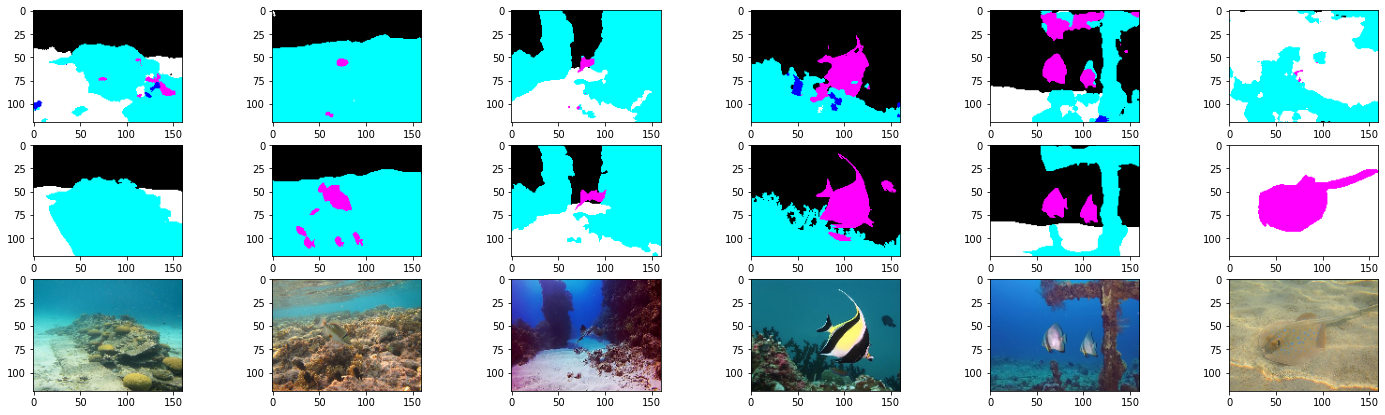

In [ ]:
processImage(model)

# Вариант **2** - **Самописная сеть на основе PSPNet**

In [ ]:
def pspnet(num_classes=8, input_shape=(120, 160, 3)):
  img_input = Input(input_shape)

  x = Conv2D(64, (3,3), padding='same')(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Pooling
  block_1_out = MaxPooling2D((2,2))(x)
  block_2_out = MaxPooling2D((4,4))(x)
  block_3_out = MaxPooling2D((8,8))(x)
  block_4_out = MaxPooling2D((40,40))(x)

  block_5_out = MaxPooling2D((2,2))(x)
  block_6_out = MaxPooling2D((4,4))(x)
  block_7_out = MaxPooling2D((8,8))(x)
  block_8_out = MaxPooling2D((40,40))(x)

  # Серточные слои
  block_1_out = Conv2D(128, (3,3), padding='same')(block_1_out)
  block_1_out = BatchNormalization()(block_1_out)
  block_1_out = Activation('relu')(block_1_out)

  block_2_out = Conv2D(128, (3,3), padding='same')(block_2_out)
  block_2_out = BatchNormalization()(block_2_out)
  block_2_out = Activation('relu')(block_2_out)

  block_3_out = Conv2D(128, (3,3), padding='same')(block_3_out)
  block_3_out = BatchNormalization()(block_3_out)
  block_3_out = Activation('relu')(block_3_out)

  block_4_out = Conv2D(128, (3,3), padding='same')(block_4_out)
  block_4_out = BatchNormalization()(block_4_out)
  block_4_out = Activation('relu')(block_4_out)

  block_5_out = Conv2D(128, (3,3), padding='same')(block_5_out)
  block_5_out = BatchNormalization()(block_5_out)
  block_5_out = Activation('relu')(block_5_out)

  block_6_out = Conv2D(128, (3,3), padding='same')(block_6_out)
  block_6_out = BatchNormalization()(block_6_out)
  block_6_out = Activation('relu')(block_6_out)

  block_7_out = Conv2D(128, (3,3), padding='same')(block_7_out)
  block_7_out = BatchNormalization()(block_7_out)
  block_7_out = Activation('relu')(block_7_out)

  block_8_out = Conv2D(128, (3,3), padding='same')(block_8_out)
  block_8_out = BatchNormalization()(block_8_out)
  block_8_out = Activation('relu')(block_8_out)



  # Conv2DTranspose
  block_1_out = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(block_1_out)
  block_1_out = BatchNormalization()(block_1_out)
  block_1_out = Activation('relu')(block_1_out)

  block_2_out = Conv2DTranspose(64, (3,3), strides=(4,4), padding='same')(block_2_out)
  block_2_out = BatchNormalization()(block_2_out)
  block_2_out = Activation('relu')(block_2_out)

  block_3_out = Conv2DTranspose(64, (3,3), strides=(8,8), padding='same')(block_3_out)
  block_3_out = BatchNormalization()(block_3_out)
  block_3_out = Activation('relu')(block_3_out)

  block_4_out = Conv2DTranspose(64, (3,3), strides=(40,40), padding='same')(block_4_out)
  block_4_out = BatchNormalization()(block_4_out)
  block_4_out = Activation('relu')(block_4_out)

  block_5_out = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(block_5_out)
  block_5_out = BatchNormalization()(block_5_out)
  block_5_out = Activation('relu')(block_5_out)

  block_6_out = Conv2DTranspose(64, (3,3), strides=(4,4), padding='same')(block_6_out)
  block_6_out = BatchNormalization()(block_6_out)
  block_6_out = Activation('relu')(block_6_out)

  block_7_out = Conv2DTranspose(64, (3,3), strides=(8,8), padding='same')(block_7_out)
  block_7_out = BatchNormalization()(block_7_out)
  block_7_out = Activation('relu')(block_7_out)

  block_8_out = Conv2DTranspose(64, (3,3), strides=(40,40), padding='same')(block_8_out)
  block_8_out = BatchNormalization()(block_8_out)
  block_8_out = Activation('relu')(block_8_out)

  # Объединение слоев
  out = concatenate([block_1_out, block_2_out, block_3_out, block_4_out, block_5_out, block_6_out, block_7_out, block_8_out])
  print(out.shape)
  # Выходной слой
  out = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(out)
  print(out.shape)
  model = Model(img_input, out)

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

  return model

In [ ]:
# Создание модели
pspnet_model = pspnet()

## Просмотр модели

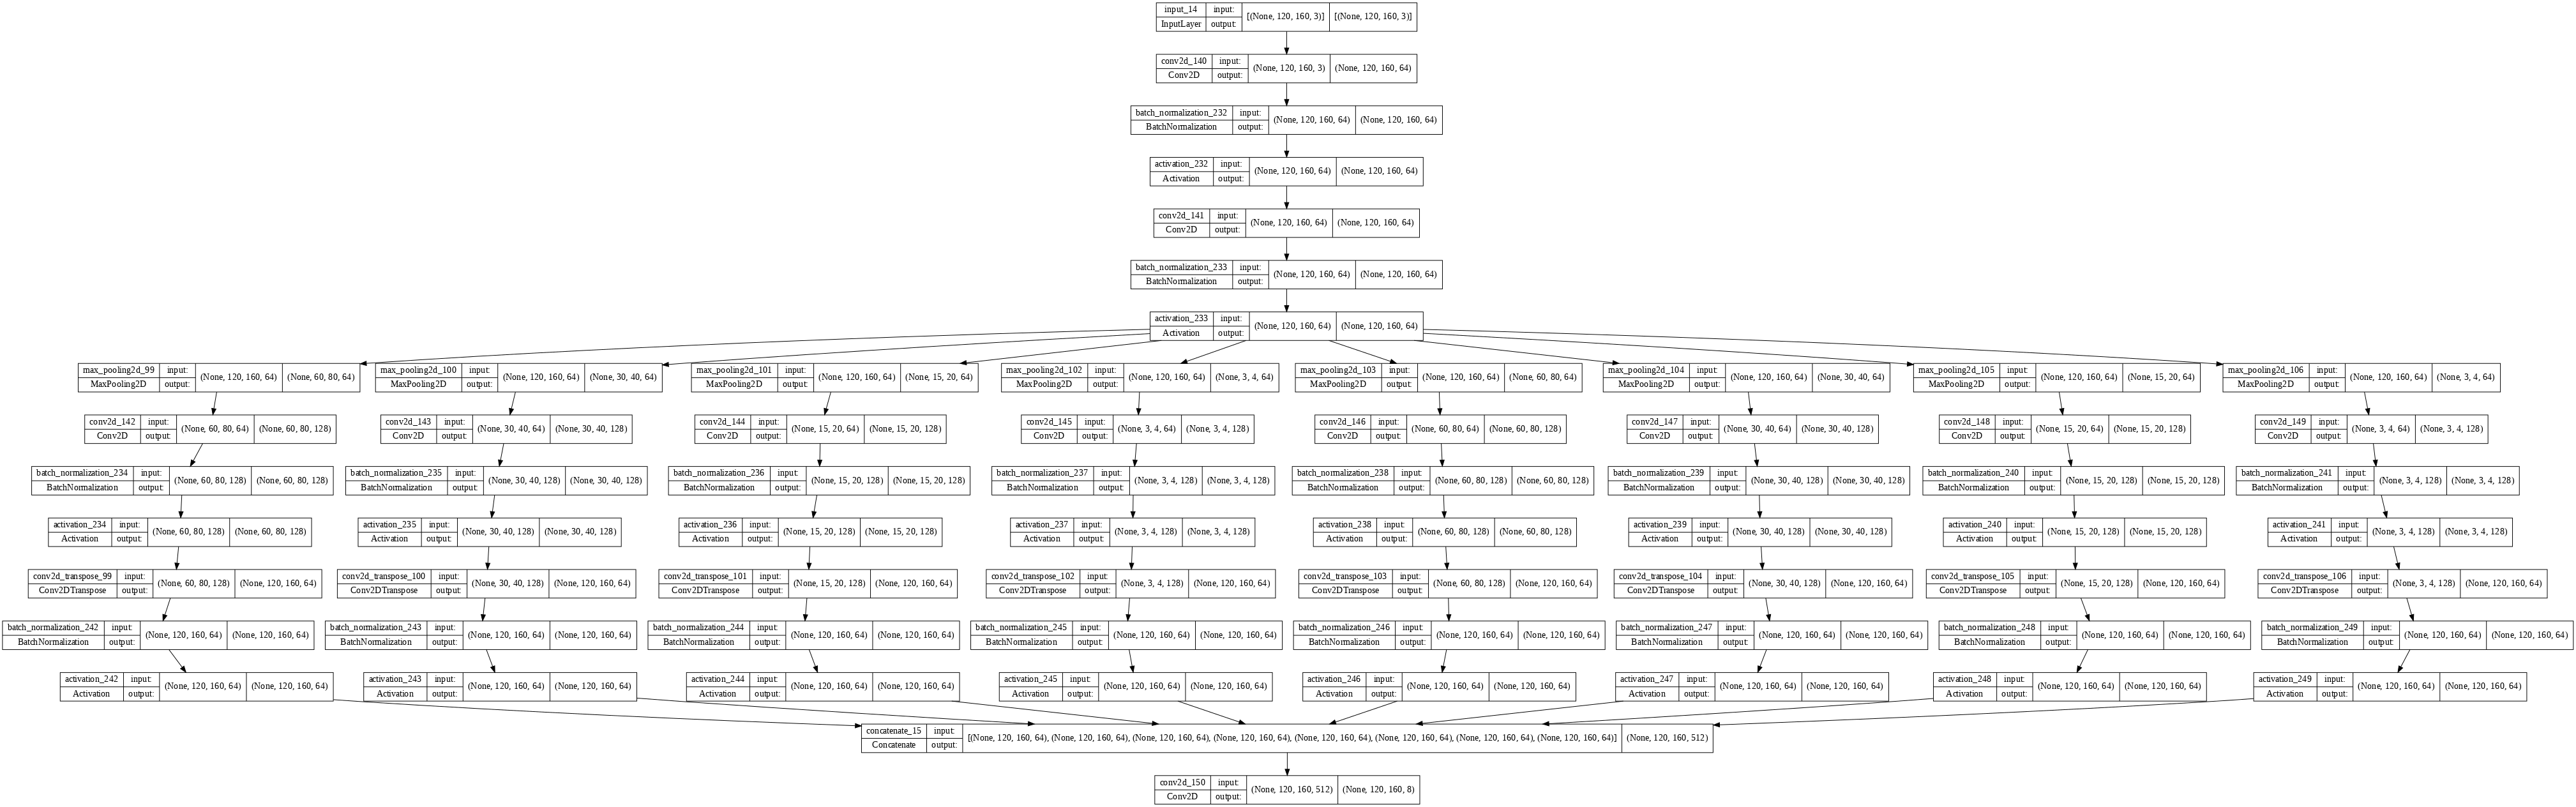

In [ ]:
plot_model(pspnet_model, show_shapes=True, dpi=70)

## Обучение

In [ ]:
history_pspnet = pspnet_model.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data = (xVal, yVal))

Epoch 1/50
96/96 [==============================] - 51s 473ms/step - loss: 1.2741 - dice_coef: 0.4180 - val_loss: 1.5082 - val_dice_coef: 0.2423
Epoch 2/50
96/96 [==============================] - 41s 430ms/step - loss: 1.1249 - dice_coef: 0.4653 - val_loss: 1.2294 - val_dice_coef: 0.3535
Epoch 3/50
96/96 [==============================] - 41s 430ms/step - loss: 1.0942 - dice_coef: 0.4778 - val_loss: 1.0783 - val_dice_coef: 0.4424
Epoch 4/50
96/96 [==============================] - 41s 429ms/step - loss: 1.0701 - dice_coef: 0.4848 - val_loss: 1.0271 - val_dice_coef: 0.4910
Epoch 5/50
96/96 [==============================] - 41s 429ms/step - loss: 1.0457 - dice_coef: 0.4952 - val_loss: 1.0313 - val_dice_coef: 0.5204
Epoch 6/50
96/96 [==============================] - 41s 429ms/step - loss: 1.0384 - dice_coef: 0.5010 - val_loss: 1.0034 - val_dice_coef: 0.5087
Epoch 7/50
96/96 [==============================] - 41s 430ms/step - loss: 1.0288 - dice_coef: 0.5057 - val_loss: 0.9863 - val_dic

In [ ]:
# Посмотрим лучших результат
max(history_pspnet.history['val_dice_coef']) * 100

59.8904550075531

In [ ]:
# Сохраним полученные веса
pspnet_model.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/pspnet_model.h5')

## Дообучение **batch_size=32**

In [ ]:
history_pspnet = pspnet_model.fit(xTrain, yTrain, epochs=50, batch_size=32, validation_data = (xVal, yVal))

Epoch 1/50
48/48 [==============================] - 54s 1s/step - loss: 0.8245 - dice_coef: 0.5904 - val_loss: 0.8430 - val_dice_coef: 0.5765
Epoch 2/50
48/48 [==============================] - 45s 941ms/step - loss: 0.8225 - dice_coef: 0.5884 - val_loss: 0.8677 - val_dice_coef: 0.5860
Epoch 3/50
48/48 [==============================] - 45s 940ms/step - loss: 0.8245 - dice_coef: 0.5927 - val_loss: 0.8826 - val_dice_coef: 0.5599
Epoch 4/50
48/48 [==============================] - 45s 938ms/step - loss: 0.8199 - dice_coef: 0.5913 - val_loss: 0.8314 - val_dice_coef: 0.5840
Epoch 5/50
48/48 [==============================] - 45s 940ms/step - loss: 0.8198 - dice_coef: 0.5947 - val_loss: 0.8338 - val_dice_coef: 0.5967
Epoch 6/50
48/48 [==============================] - 45s 938ms/step - loss: 0.8211 - dice_coef: 0.5921 - val_loss: 0.8435 - val_dice_coef: 0.6064
Epoch 7/50
48/48 [==============================] - 45s 938ms/step - loss: 0.8150 - dice_coef: 0.5962 - val_loss: 0.8679 - val_dice_c

In [ ]:
# Посмотрим лучших результат
max(history_pspnet.history['val_dice_coef']) * 100

61.09819412231445

In [ ]:
# Сохраним полученные веса
pspnet_model.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/pspnet_model.h5')

## Дообучение **batch_size=50, lr=0.00001**

In [ ]:
pspnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=[dice_coef])
history_pspnet = pspnet_model.fit(xTrain, yTrain, epochs=50, batch_size=16, validation_data = (xVal, yVal))

Epoch 1/50
96/96 [==============================] - 44s 436ms/step - loss: 0.7778 - dice_coef: 0.6143 - val_loss: 0.8196 - val_dice_coef: 0.6185
Epoch 2/50
96/96 [==============================] - 41s 428ms/step - loss: 0.7721 - dice_coef: 0.6109 - val_loss: 0.8277 - val_dice_coef: 0.6137
Epoch 3/50
96/96 [==============================] - 41s 428ms/step - loss: 0.7692 - dice_coef: 0.6139 - val_loss: 0.8241 - val_dice_coef: 0.6181
Epoch 4/50
96/96 [==============================] - 41s 428ms/step - loss: 0.7710 - dice_coef: 0.6131 - val_loss: 0.8197 - val_dice_coef: 0.6194
Epoch 5/50
96/96 [==============================] - 41s 428ms/step - loss: 0.7703 - dice_coef: 0.6115 - val_loss: 0.8232 - val_dice_coef: 0.6164
Epoch 6/50
96/96 [==============================] - 41s 428ms/step - loss: 0.7690 - dice_coef: 0.6135 - val_loss: 0.8208 - val_dice_coef: 0.6182
Epoch 7/50
96/96 [==============================] - 41s 428ms/step - loss: 0.7682 - dice_coef: 0.6148 - val_loss: 0.8215 - val_dic

In [ ]:
# Посмотрим лучших результат
max(history_pspnet.history['val_dice_coef']) * 100

62.48334050178528

In [ ]:
# Сохраним полученные веса
pspnet_model.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/pspnet_model.h5')

## Распознавание



In [ ]:
# Если нужно то снова создадим модель и загрузим веса
# pspnet_model = pspnet()
# pspnet_model.load_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/pspnet_model.h5')

indexes:  [62 29 41 43 29 21]


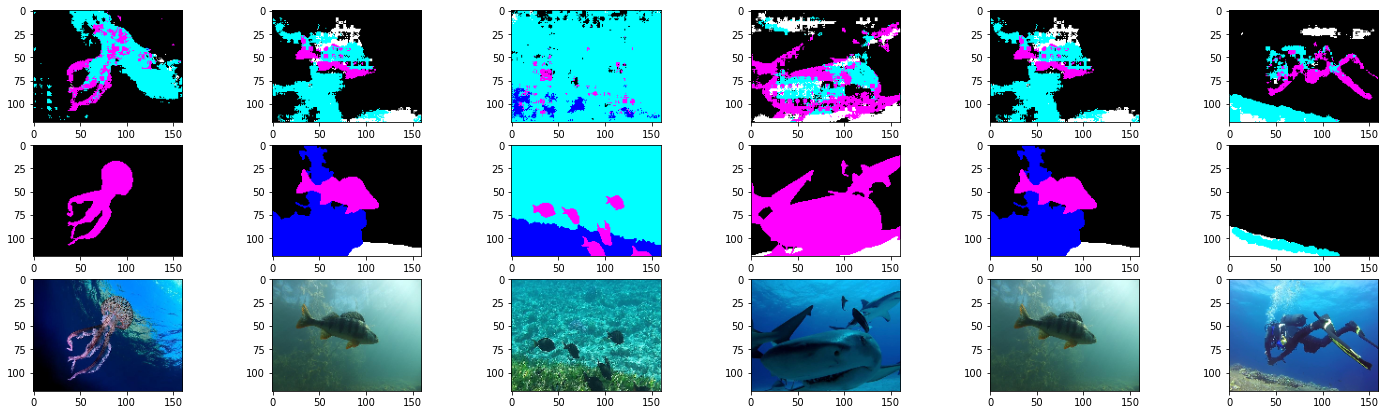

In [ ]:
processImage(pspnet_model)

# Наложение маски

In [ ]:
count = 5
n_classes = 8
indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(pspnet_model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
plt.show() 

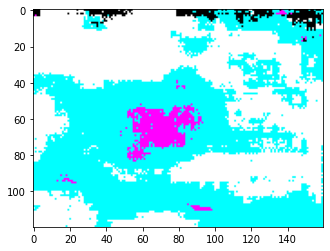

In [ ]:
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
plt.imshow(seg)
plt.show()

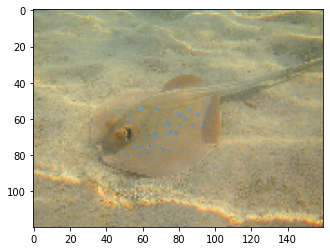

In [ ]:
plt.imshow(Image.fromarray(xVal[idx].astype('uint8')))
plt.show()

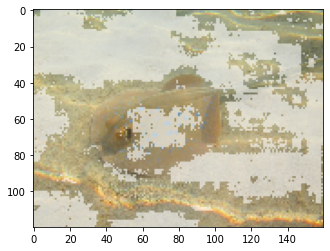

In [ ]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [255, 255, 255, 150]

img2 = Image.fromarray(xVal[idx].astype('uint8'))
img = Image.fromarray(mask).convert('RGBA')
img2.paste(img, (0, 0),img)
plt.imshow(img2)
plt.show()

# **Вариат 3**. Простая линейная сеть

In [ ]:
def linear(num_classes = 8,input_shape = (120, 160, 3)):
    
    img_input = Input(input_shape)                                          
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) 
    x = BatchNormalization()(x)                                             
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[dice_coef])
    return model 

In [ ]:
model_linear = linear()

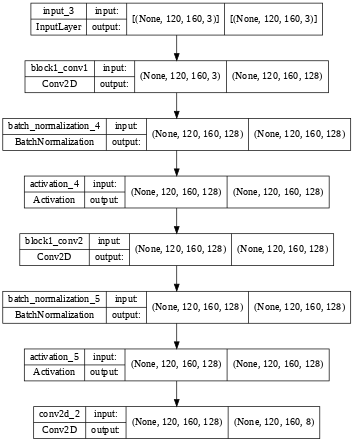

In [ ]:
plot_model(model_linear, show_shapes=True, dpi=50)

In [ ]:
history_linear = model_linear.fit(xTrain, yTrain, epochs=50, batch_size=32, validation_data=(xVal, yVal)) 

Epoch 1/50
48/48 [==============================] - 23s 219ms/step - loss: 1.4502 - dice_coef: 0.3702 - val_loss: 1.4461 - val_dice_coef: 0.4216
Epoch 2/50
48/48 [==============================] - 8s 164ms/step - loss: 1.2133 - dice_coef: 0.4262 - val_loss: 1.2533 - val_dice_coef: 0.3903
Epoch 3/50
48/48 [==============================] - 8s 165ms/step - loss: 1.1814 - dice_coef: 0.4346 - val_loss: 1.2469 - val_dice_coef: 0.3787
Epoch 4/50
48/48 [==============================] - 8s 166ms/step - loss: 1.1590 - dice_coef: 0.4450 - val_loss: 1.2099 - val_dice_coef: 0.3928
Epoch 5/50
48/48 [==============================] - 8s 167ms/step - loss: 1.1461 - dice_coef: 0.4463 - val_loss: 1.2027 - val_dice_coef: 0.3999
Epoch 6/50
48/48 [==============================] - 8s 170ms/step - loss: 1.1331 - dice_coef: 0.4546 - val_loss: 1.2043 - val_dice_coef: 0.4009
Epoch 7/50
48/48 [==============================] - 8s 169ms/step - loss: 1.1191 - dice_coef: 0.4594 - val_loss: 1.1435 - val_dice_coef

In [ ]:
# Посмотрим лучших результат
max(history_linear.history['val_dice_coef']) * 100

52.802473306655884

In [ ]:
# Сохраним полученные веса
model_linear.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/model_linear.h5')

## Дообучение **batch_size=32**

In [ ]:
history_linear = model_linear.fit(xTrain, yTrain, epochs=50, batch_size=50, validation_data = (xVal, yVal))

Epoch 1/50
31/31 [==============================] - 9s 279ms/step - loss: 0.9725 - dice_coef: 0.5228 - val_loss: 1.0138 - val_dice_coef: 0.5038
Epoch 2/50
31/31 [==============================] - 9s 280ms/step - loss: 0.9753 - dice_coef: 0.5237 - val_loss: 1.0047 - val_dice_coef: 0.4972
Epoch 3/50
31/31 [==============================] - 9s 283ms/step - loss: 0.9720 - dice_coef: 0.5217 - val_loss: 1.0244 - val_dice_coef: 0.4874
Epoch 4/50
31/31 [==============================] - 9s 287ms/step - loss: 0.9701 - dice_coef: 0.5243 - val_loss: 1.0102 - val_dice_coef: 0.5155
Epoch 5/50
31/31 [==============================] - 9s 289ms/step - loss: 0.9711 - dice_coef: 0.5243 - val_loss: 1.0257 - val_dice_coef: 0.4950
Epoch 6/50
31/31 [==============================] - 9s 291ms/step - loss: 0.9785 - dice_coef: 0.5218 - val_loss: 0.9796 - val_dice_coef: 0.5228
Epoch 7/50
31/31 [==============================] - 9s 295ms/step - loss: 0.9722 - dice_coef: 0.5258 - val_loss: 1.0243 - val_dice_coef:

In [ ]:
# Посмотрим лучших результат
max(history_linear.history['val_dice_coef']) * 100

53.77437472343445

In [ ]:
# Сохраним полученные веса
model_linear.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/model_linear.h5')

## Дообучение **batch_size=50, lr=0.00001**

In [ ]:
 model_linear.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=[dice_coef])
 history_linear = model_linear.fit(xTrain, yTrain, epochs=50, batch_size=30, validation_data = (xVal, yVal))

Epoch 1/50
51/51 [==============================] - 9s 164ms/step - loss: 0.9355 - dice_coef: 0.5414 - val_loss: 0.9457 - val_dice_coef: 0.5467
Epoch 2/50
51/51 [==============================] - 8s 161ms/step - loss: 0.9314 - dice_coef: 0.5394 - val_loss: 0.9444 - val_dice_coef: 0.5433
Epoch 3/50
51/51 [==============================] - 8s 163ms/step - loss: 0.9303 - dice_coef: 0.5393 - val_loss: 0.9416 - val_dice_coef: 0.5456
Epoch 4/50
51/51 [==============================] - 8s 164ms/step - loss: 0.9276 - dice_coef: 0.5417 - val_loss: 0.9439 - val_dice_coef: 0.5472
Epoch 5/50
51/51 [==============================] - 9s 167ms/step - loss: 0.9284 - dice_coef: 0.5415 - val_loss: 0.9467 - val_dice_coef: 0.5365
Epoch 6/50
51/51 [==============================] - 9s 168ms/step - loss: 0.9310 - dice_coef: 0.5388 - val_loss: 0.9404 - val_dice_coef: 0.5422
Epoch 7/50
51/51 [==============================] - 9s 168ms/step - loss: 0.9270 - dice_coef: 0.5407 - val_loss: 0.9415 - val_dice_coef:

In [ ]:
# Посмотрим лучших результат
max(history_linear.history['val_dice_coef']) * 100

55.174654722213745

In [ ]:
# Сохраним полученные веса
model_linear.save_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/model_linear.h5')

## Распознавание



In [ ]:
# Если нужно то снова создадим модель и загрузим веса
# model_linear = linear()
# model_linear.load_weights('/content/drive/MyDrive/УИИ/Сегментация изображений/SUIM/model_linear.h5')

indexes:  [98 22 75 50 64 54]


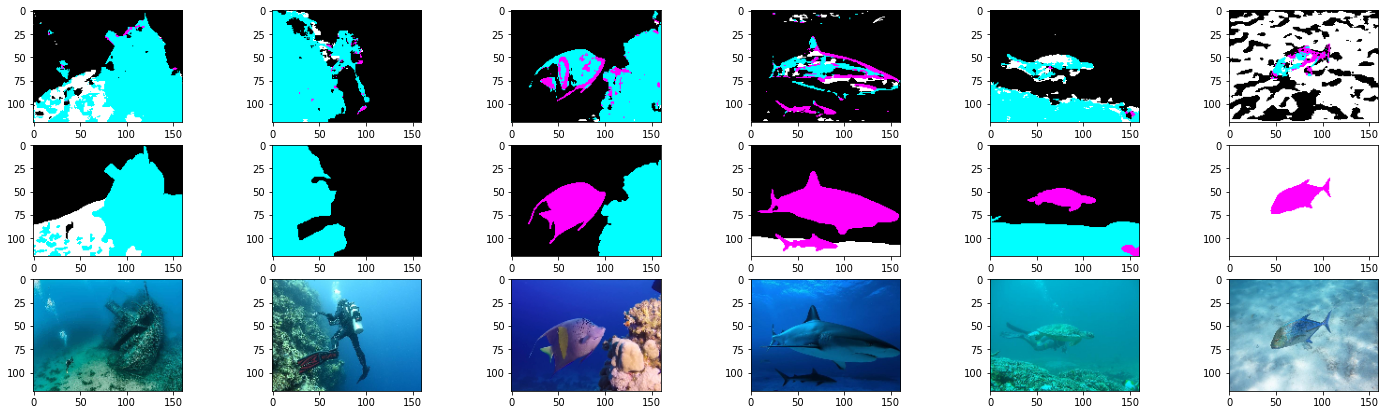

In [ ]:
processImage(model_linear)

# Выводы:

1. Для выполнения данной задачи требуется правильно подготовить обучающие данные и верно разменить сегментирующие изображения (**8** классов)
2. В данной работе было опробовано 3 разные архитектуры сети
   - U-Net **73.16%**
   - Самописная сеть на основе PSPNet  **62.48%**
   - Простая линейная сеть **55.17%**
4. Как видно лучit всех результат у архитектуры **U-Net**
5. Так же можно отметить что довольно простая линейная сеть, показала результат не намного хуже, чем сложная **PSPNet**. 
6. Это говорит о том, что начинать надо с более простых архитектур.
7. Увеличение обучающей базы (сейчас **1525** изображений) увеличит точность работы сети.
8. Для достижения лучшего результата надо не только подбирать конкретную архитектуру, но и менять разрешение обучающих изображений, а так же подбирать оптимальные гиперпараметры.
9. Так же использование callback как изменение шага обучения и сохранения лучших резульатов помогут добиться и сохранить лучший результат для дальнейшей работы.